**Automatic Number Plate Recognition System**

# Mounting Drive

In [ ]:
# Mounting Drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Preprocessing the dataset

In [ ]:
#importing the required libraries
import os
import cv2
import numpy as np

#storing the location of datasets
data_path = "gdrive/My Drive/DataSets/ALRP_System/English/Img/"

#creating the directory to store the preprocessed images
preprocessed_img_path = "gdrive/My Drive/DataSets/ALRP_System/preprocessed_images"

# Finding all the directories and files in the dataset
for root, dirs, files in os.walk(data_path):
    for file in files:
        #creating the path to store the preprocessed image
        temp = root.split("/")
        temp2 = temp[5:]
        temp2 = "/".join(temp2)
        #preprocessed_img_path = os.path.join(preprocessed_img_path, root[len(data_path):])
        preprocessed_path = os.path.join(preprocessed_img_path, temp2)
        #print(preprocessed_img_path)
        if not os.path.exists(preprocessed_path):
          #creating the path for each image
          img_path = os.path.join(root, file)

          #reading each image
          img = cv2.imread(img_path)

          #preprocessing the image
          img = cv2.resize(img,(256,256)) #Resizing the image
          img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #Converting the image to grayscale
          img_blur = cv2.GaussianBlur(img_gray,(5,5),0) #Applying Gaussian blur to the grayscale image
          img_edges = cv2.Canny(img_blur,100,200) #Applying Canny edge detection to the blurred image
          preprocessed_img = np.expand_dims(img_edges,axis=2) #Expanding the dimensions of the edges image

          #creating the directory if it doesn't exists
          if not os.path.exists(preprocessed_path):
              os.makedirs(preprocessed_path)

          #storing the preprocessed image
          cv2.imwrite(os.path.join(preprocessed_path, file), preprocessed_img)

print("Preprocessing complete!")

Preprocessing complete!


# Principle Component Analysis

In [ ]:
# Installing Required Libraries
!pip install scikit-learn
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing Necessary Libraries and Packages

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# Set directory of preprocessed images
preprocessed_dir = '/content/gdrive/MyDrive/DataSets/ALRP_System/preprocessed_images'

# Create image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Create image generator from directory
image_generator = datagen.flow_from_directory(
    preprocessed_dir,
    target_size=(100, 100),  # set the target image size
    color_mode='grayscale',  # set the color mode to grayscale
    class_mode=None,  # set the class mode to None
    batch_size=32,  # set the batch size
    shuffle=False  # set shuffle to False to preserve the order of the images
)


Found 25765 images belonging to 3 classes.


In [ ]:
# Get the preprocessed images as a numpy array
X = np.concatenate([image_generator.next() for i in range(image_generator.samples//image_generator.batch_size)])

# Flatten the images to a 2D array
X = X.reshape(X.shape[0], -1)



The above part takes a longer time to run. So, the values of the variable is stored in a file and loaded when needed.

In [ ]:
np.save('gdrive/My Drive/saved_X.npy', X)

In [ ]:
# Load the saved X from the file
X = np.load('gdrive/MyDrive/saved_X.npy')

Scree Plot to determint the number of components required for PCA

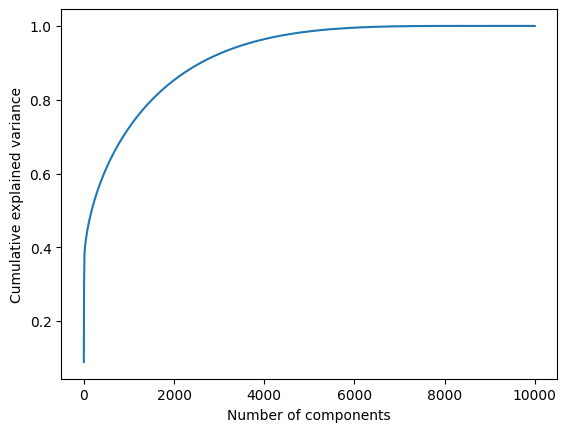

In [ ]:
processed_data = X
pca_scree = PCA().fit(processed_data)

# Plot the scree plot
plt.plot(np.cumsum(pca_scree.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
np.save('gdrive/My Drive/saved_pca_scree.npy', np.cumsum(pca_scree.explained_variance_ratio_))

In [ ]:
# Perform PCA on the preprocessed images
pca = PCA(n_components=4500)
X_pca = pca.fit_transform(X)

In [ ]:
# Save the necessary components to a file
np.savez('gdrive/My Drive/saved_pca.npz',
         components=pca.components_,
         explained_variance=pca.explained_variance_,
         mean=pca.mean_,
         X_pca=X_pca)

In [ ]:
# Load the saved components from the file
saved_data = np.load('gdrive/MyDrive/saved_pca.npz')

# Retrieve the saved components
components = saved_data['components']
explained_variance = saved_data['explained_variance']
mean = saved_data['mean']
X_pca = saved_data['X_pca']

# Create a new PCA object and set the saved components
pca = PCA(n_components=4500)
pca.components_ = components
pca.explained_variance_ = explained_variance
pca.mean_ = mean

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Reshape and normalize the input data for the generator model
X_pca = X_pca.reshape(-1, 10, 10, 1)
X_pca = (X_pca - np.min(X_pca)) / (np.max(X_pca) - np.min(X_pca))

# Define the Generator model
generator = Sequential()
generator.add(Dense(128 * 10 * 10, input_shape=(10, 10, 1), activation='relu'))
generator.add(Reshape((10, 10, 128)))
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'))
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'))

# Define the Discriminator model
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(10, 10, 1)))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

# Compile the models
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')
discriminator.trainable = False
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# Training loop
batch_size = 32
epochs = 100
steps_per_epoch = len(X_pca) // batch_size

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # Generate random noise
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate fake images from noise
        generated_images = generator.predict(noise)

        # Select a random batch of real images
        real_images = X_pca[np.random.randint(0, len(X_pca), batch_size)]

        # Concatenate real and fake images
        combined_images = np.concatenate([real_images, generated_images])

        # Labels for generated and real data
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        # Train the discriminator
        discriminator_loss = discriminator.train_on_batch(combined_images, labels)

        # Generate new random noise
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Labels for generated data (tricking the discriminator)
        misleading_targets = np.zeros((batch_size, 1))

        # Train the generator (via the GAN model)
        gan_loss = gan.train_on_batch(noise, misleading_targets)

In [ ]:
!pip install easyocr
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.72
    Uninstalling opencv-python-headless-4.7.0.72:
      Successfully uninstalled opencv-python-headless-4.7.0.72
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

In [ ]:
# Mounting Drive
from google.colab import drive
#import shutil  #To Extract files in Drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


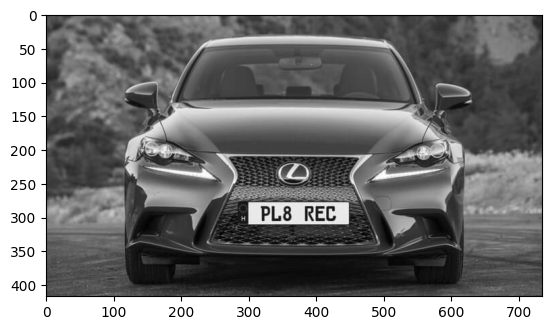

In [ ]:
img = cv2.imread("gdrive/MyDrive/DataSets/image7.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB))

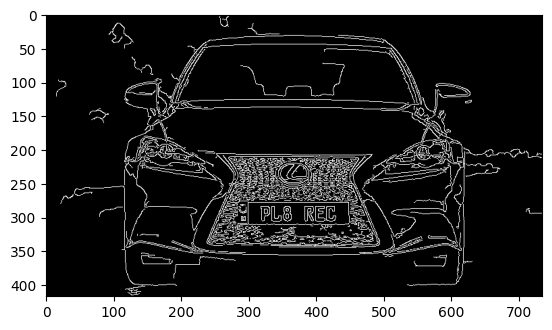

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(bfilter, 10, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [ ]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [ ]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [ ]:
location

array([[[299, 279]],

       [[447, 278]],

       [[449, 308]],

       [[301, 311]]], dtype=int32)

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
new_image =  cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask= mask)

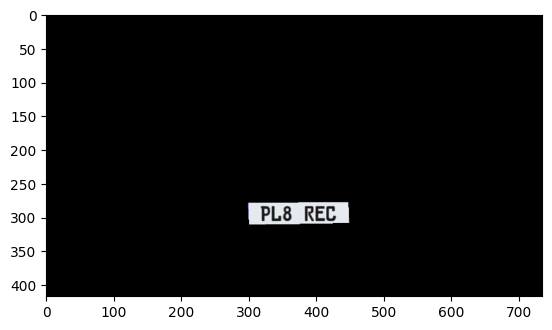

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [ ]:
(x,y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

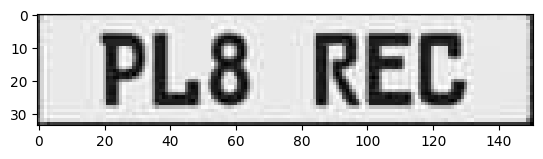

In [ ]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [ ]:
# Generate random noise
noise = np.random.normal(0, 1, (1, latent_dim))

# Generate fake image from noise
generated_image = generator.predict(noise)

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(generated_image)
result

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

[([[16, 2], [70, 2], [70, 34], [16, 34]], 'PL8', 0.5099071860313416),
 ([[80, 2], [136, 2], [136, 34], [80, 34]], 'REC', 0.999786919245981)]